# Simulated spectra for signals and noise

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 1

import time
import numpy as np
# from scipy import stats, fft
import scipy.stats
import scipy.fft
import matplotlib
matplotlib.rcParams['figure.dpi'] = 90

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

%aimport detectors

diodes = detectors.diodes
TIA = detectors.TIA()

savefig = True
ifig = 1

AP PDB-C164 disc. PIN
  QE = 81.3 %
  Resp. = 0.43 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 7.0 pF
  Shunt res. = 500 MOhms
  Ref. bias voltage = 10 V
  Ref. temp. = 20 C
Hama. S13620 8x8 PIN
  QE = 92.6 %
  Resp. = 0.49 A/W
  Dark current (total or vol.) = 0.3 nA
  Junction cap = 15.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 9 V
  Ref. temp. = 20 C
AP SD197 disc. APD
  QE = 76.0 %
  Resp. = 0.40 A/W
  Dark current (total or vol.) = 6.0 nA
  Junction cap = 25.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 1800 V
  Ref. temp. = 20 C
  Gain = 300
  Noise factor = 2.2
Hama. S8550 4x8 APD
  QE = 85.0 %
  Resp. = 0.45 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 9.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 330 V
  Ref. temp. = 20 C
  Gain = 50
  Noise index = 0.20
  Noise factor = 2.2


In [2]:
nfft = 2048  # FFT bin size
nbins = 64
oversample = 1
nsamples = nbins * nfft // oversample
print(f'Samples in signal window = {nsamples}')

f_sample = 2e6  # sample rate, samples/s (Hz)
bw = f_sample / 2
f_res = f_sample / nfft  # FFT freq. resolution (Hz)
print(f'FFT freq. resolution = {f_res/1e3:.3f} kHz')

time_array = np.arange(nsamples) / f_sample

Samples in signal window = 131072
FFT freq. resolution = 0.977 kHz


In [3]:
rng = np.random.default_rng()

i2 = 1e-6
I_rms = np.sqrt(i2*bw)

# signal 1: N(0,1) samples and I_rms
s1_name = 'N(0,1) samples'
tmp = time.time()
signal_1 = I_rms * rng.standard_normal(nsamples)
print(f'Time = {time.time()-tmp:.3f} s')

# signal 2 from fourier comp and ifft
s2_name = 'IFFT with N(0,1) amp.'
tmp = time.time()
freqs = scipy.fft.fftfreq(nsamples, 1/f_sample)
nfreqs = freqs.size
fres = freqs[1]
amplitudes = np.sqrt(i2*fres) * rng.standard_normal(nfreqs)  # A = rt(2) * RMS
amplitudes[0] = 0
amplitudes[nsamples//2] *= np.sqrt(2)
phases = 2*np.pi * rng.random(nfreqs)
fourier_comp = amplitudes * np.exp(1.j * phases)
signal_2 = np.real( scipy.fft.ifft(fourier_comp, norm='forward') )
print(f'Time = {time.time()-tmp:.3f} s')

Time = 0.002 s
Time = 0.015 s


N(0,1) samples
  RMS = 1.0031e+00
  RMS rel. error = 3.09e-03
  Normal skew p-value = 0.35 (not std. norm. if < 0.05)
  Normal kurtosis p-value = 0.10 (not std. norm. if < 0.05)
IFFT with N(0,1) amp.
  RMS = 9.9799e-01
  RMS rel. error = 2.01e-03
  Normal skew p-value = 0.20 (not std. norm. if < 0.05)
  Normal kurtosis p-value = 0.06 (not std. norm. if < 0.05)


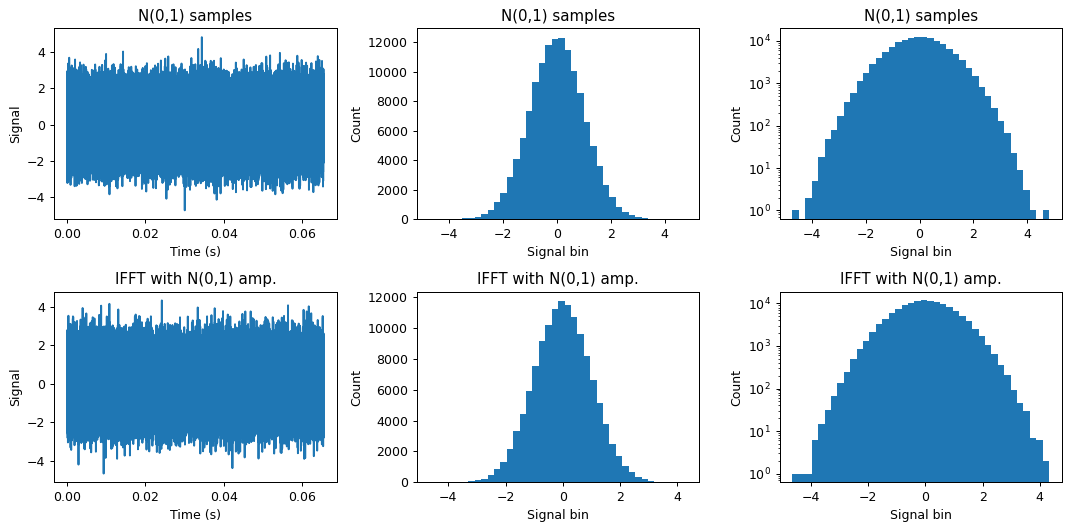

In [4]:
ncols, nrows = 3, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0
hist_bins = 40
# for signal, name in zip([signal_1, signal_2, signal_3], [s1_name, s2_name, s3_name]):
for signal, name in zip([signal_1, signal_2], [s1_name, s2_name]):
    print(name)
    rms = np.sqrt(np.mean(signal**2))
    print(f'  RMS = {rms:.4e}')
    print(f'  RMS rel. error = {np.abs(I_rms-rms) / I_rms:.2e}')

    _, skew_pvalue = scipy.stats.skewtest(signal)
    _, kurtosis_pvalue = scipy.stats.kurtosistest(signal)
    print(f'  Normal skew p-value = {skew_pvalue:.2f} (not std. norm. if < 0.05)')
    print(f'  Normal kurtosis p-value = {kurtosis_pvalue:.2f} (not std. norm. if < 0.05)')

    plt.sca(axes.flat[iax])
    plt.plot(time_array, signal)
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=hist_bins)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=hist_bins, log=True)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    iax += 1

plt.tight_layout()

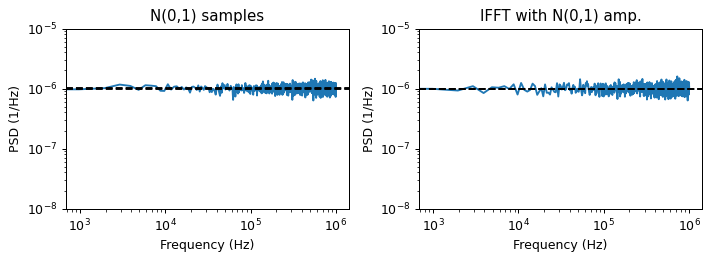

In [5]:
ncols, nrows = 2,1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0

freqs = scipy.fft.rfftfreq(nsamples, 1/f_sample)
freqs2 = scipy.fft.rfftfreq(nfft, 1/f_sample)

# for signal, name in zip([signal_1, signal_2, signal_3], [s1_name, s2_name, s3_name]):
for signal, name in zip([signal_1, signal_2], [s1_name, s2_name]):
    # psd = np.abs(fft.rfft(signal)) ** 2 / nsamples / bw
    psd2 = np.empty([nfft//2+1, nbins])
    for i in np.arange(nbins):
        rfft = scipy.fft.rfft( signal[nfft*i:nfft*(i+1)] )
        psd2[:,i] = np.abs(rfft) ** 2 / nfft / bw
    mean_psd = np.mean(psd2, axis=1)
    plt.sca(axes.flat[iax])
    # plt.loglog(freqs, psd)
    plt.loglog(freqs2, mean_psd)
    plt.title(name)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (1/Hz)')
    plt.ylim(i2/1e2,i2*1e1)
    plt.axhline(np.mean(mean_psd), c='k', ls='--')
    plt.axhline(i2, c='k', ls='--')
    iax += 1

plt.tight_layout()